In [1]:
# import libraries

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

%run ./scripts/util_func.py
%run ./scripts/model_func.py

In [2]:
# import arrays

icp_states = np.load('data/icp_states_nojoy_tracks_LS.npy', allow_pickle=True) # [time, icp_index, icp_x, icp_y, icp_yaw]
wheel_vels = np.load('data/wheel_vels_nojoy_tracks_LS.npy', allow_pickle=True) # [time, icp_index, vel_l, vel_r]
wheel_vels_pwrtrn = np.load('data/wheel_vels_pwrtrn_nojoy_tracks_LS.npy', allow_pickle=True) # [time, icp_index, vel_l, vel_r]

print(icp_states)

[[0.0 19.0 0.016561567783355713 -0.009285315871238708 -0.4661190836648743]
 [0.050337280000000005 20.0 0.01767536997795105 -0.010052084922790527
  -0.46614475654293813]
 [0.100604672 20.0 0.01767536997795105 -0.010052084922790527
  -0.46614475654293813]
 ...
 [735.253571328 7372.0 -14.319028854370115 12.176901817321776
  3.0448653658128833]
 [735.303886336 7372.0 -14.319028854370115 12.176901817321776
  3.0448653658128833]
 [735.3491668480001 7373.0 -14.36957836151123 12.18723201751709
  3.0453815158253357]]


In [ ]:
# Optimize icr params for entire trajectory

# params from crv
r = 0.17 # wheel radius : meters
alpha_l = 0.5 # left side friction loss
alpha_r = 0.5 # right side friction loss
x_icr = -3.0 # vehicle x_icr
y_icr_l = 4.0 # left wheels icr in y coordinates
y_icr_r = -4.0 # right wheels icr in y coordinates
k = np.array([alpha_l, alpha_r, x_icr, y_icr_l, y_icr_r])
# k = np.array([1.0, 1.0,  1.0, 1.0, -1.0])
J_icr = np.array([[-y_icr_r, y_icr_l], [x_icr, -x_icr], [-1, 1]])
J_alpha = np.array([[alpha_l, 0], [0, alpha_r]])

def compute_err_traj(k):
    #init values
    err = 0
    edd_pose = icp_states[0, 2:]
    icp_disp = 0
    propa_cos = np.cos(icp_states[0,4])
    propa_sin = np.sin(icp_states[0,4])
    propa_mat = np.array([[propa_cos, -propa_sin, 0.0], 
                      [propa_sin, propa_cos, 0.0], [0.0, 0.0, 1.0]])
    
    for i in range(icp_states.shape[0] - 1):
        # compute error for entire trajectory
        dt = icp_states[i+1, 0] - icp_states[i, 0]
        icp_disp = icp_disp + comp_disp(icp_states[i+1, 2:3], icp_states[i, 2:3])
        
        
        propa_mat = up_propa_mat(propa_mat, edd_pose[2])
        
        edd_pose = edd_pose + propa_mat @ icr_diff_drive(wheel_vels_pwrtrn[i, 2:], k, J_icr, J_alpha) * dt
        edd_pose[2] = wrap2pi(edd_pose[2])
        
        # filter icp jumps caused by controller input
        if icp_states[i+1, 0] - icp_states[i, 0] >= 0.5:
            icp_disp = 0.0
            edd_pose = icp_states[i, 2:]
        
        # compute error every time icp disp reaches 2 m
        if icp_disp >= 1.5:
#         if icp_states[i+1,2] != icp_states[i,2]:
            err = err + disp_err(edd_pose, icp_states[i+1, 2:])
            icp_disp = 0
            edd_pose = icp_states[i+1, 2:]
    return err

print('initial error : ', compute_err_traj(k))

res = minimize(compute_err_traj, k, method='nelder-mead')
print(res)

k_train = res.x

np.save('data/icr_train_tracks_LS.npy', res.x)

initial error :  2409.4363050269376


In [6]:
# Optimize icr params for every icp hit

# params from crv
r = 0.3 # wheel radius : meters
alpha_l = 0.81 # left side friction loss
alpha_r = 0.84 # right side friction loss
x_icr = -2.71 # vehicle x_icr
y_icr_l = 3.0 # left wheels icr in y coordinates
y_icr_r = -3.85 # right wheels icr in y coordinates
k = np.array([alpha_l, alpha_r, x_icr, y_icr_l, y_icr_r])
J_icr = np.array([[-y_icr_r, y_icr_l], [x_icr, -x_icr], [-1, 1]])
J_alpha = np.array([[alpha_l, 0], [0, alpha_r]])
# k = np.array([-1.96629809e-08, -1.47389374e-08,  9.16716929e-01,  5.19340378e+00,
#        -1.07375266e+01])

def compute_err_seg(k, propa_mat, edd_pose, icp_states, index_start, index_end, wheel_vels):
    index = index_start
    while index <= index_end:
        dt = icp_states[index+1, 0] - icp_states[index, 0]
        propa_mat = up_propa_mat(propa_mat, edd_pose[2])
        edd_pose = edd_pose + propa_mat @ icr_diff_drive(wheel_vels[index, 2:], k, J_icr, J_alpha) * dt
        edd_pose[2] = wrap2pi(edd_pose[2])
        
        index = index + 1
    
    err = disp_err(edd_pose, icp_states[index+1, 2:])
    return err


err = 0
edd_pose = icp_states[0, 2:]
vel_count = 0
icp_disp = 0
index_start = 0

k_arr = np.zeros((1, k.shape[0] + 3))
k_row = np.zeros(k.shape[0] + 3)

propa_cos = np.cos(icp_states[0,4])
propa_sin = np.sin(icp_states[0,4])
propa_mat = np.array([[propa_cos, -propa_sin, 0.0], 
                  [propa_sin, propa_cos, 0.0], [0.0, 0.0, 1.0]])
    
for i in range(icp_states.shape[0] - 1):
    
    icp_disp = icp_disp + comp_disp(icp_states[i+1, 2:3], icp_states[i, 2:3])
    if icp_states[i+1, 0] - icp_states[i, 0] >= 0.5:
            icp_disp = 0.0
            index_start = i
    
    if icp_disp >= 0.5:
        index_end = i
        res_sec = minimize(compute_err_seg, k, args = (propa_mat, edd_pose, icp_states, index_start, index_end, wheel_vels), method='nelder-mead')
        k_row[0] = icp_states[i+1, 0]
        k_row[1] = res_sec.fun
        k_row[2] = compute_err_seg(res.x, propa_mat, edd_pose, icp_states, index_start, index_end, wheel_vels)
        k_row[3:] = res_sec.x
        k_arr = np.vstack((k_arr, k_row))
        index_start = i
        icp_disp = 0
        edd_pose = icp_states[i+1, 2:]
    

In [7]:
# compute prediction error for single set of trained params

err = 0
edd_pose = icp_states[0, 2:]
vel_count = 0
icp_disp = 0
index_start = 0

k = res.x

k_arr = np.zeros((1, k.shape[0] + 3))
k_row = np.zeros(k.shape[0] + 3)

propa_cos = np.cos(icp_states[0,4])
propa_sin = np.sin(icp_states[0,4])
propa_mat = np.array([[propa_cos, -propa_sin, 0.0], 
                  [propa_sin, propa_cos, 0.0], [0.0, 0.0, 1.0]])

pred_err = np.zeros(4)
pred_err_arr = []

    
for i in range(icp_states.shape[0] - 1):
    dt = icp_states[i+1, 0] - icp_states[i, 0]
    icp_disp = icp_disp + comp_disp(icp_states[i+1, 2:3], icp_states[i, 2:3])
            
    propa_mat = up_propa_mat(propa_mat, edd_pose[2])
        
    edd_pose = edd_pose + propa_mat @ icr_diff_drive(wheel_vels_pwrtrn[i, 2:], k, J_icr, J_alpha) * dt
    edd_pose[2] = wrap2pi(edd_pose[2])
    if icp_states[i+1, 0] - icp_states[i, 0] >= 0.5:
            icp_disp = 0.0
            index_start = i
    
    if icp_disp >= 0.5:
        
        pred_err[0] = icp_states[i+1,0]
        pred_err[1:] = icp_states[i+1, 2:] - edd_pose
        pred_err_arr.append(pred_err.copy())
        
        icp_disp = 0
        edd_pose = icp_states[i+1, 2:]
        
pred_err_arr = np.asarray(pred_err_arr)

np.save('data/train_residuals_doughnut1.npy', pred_err_arr)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


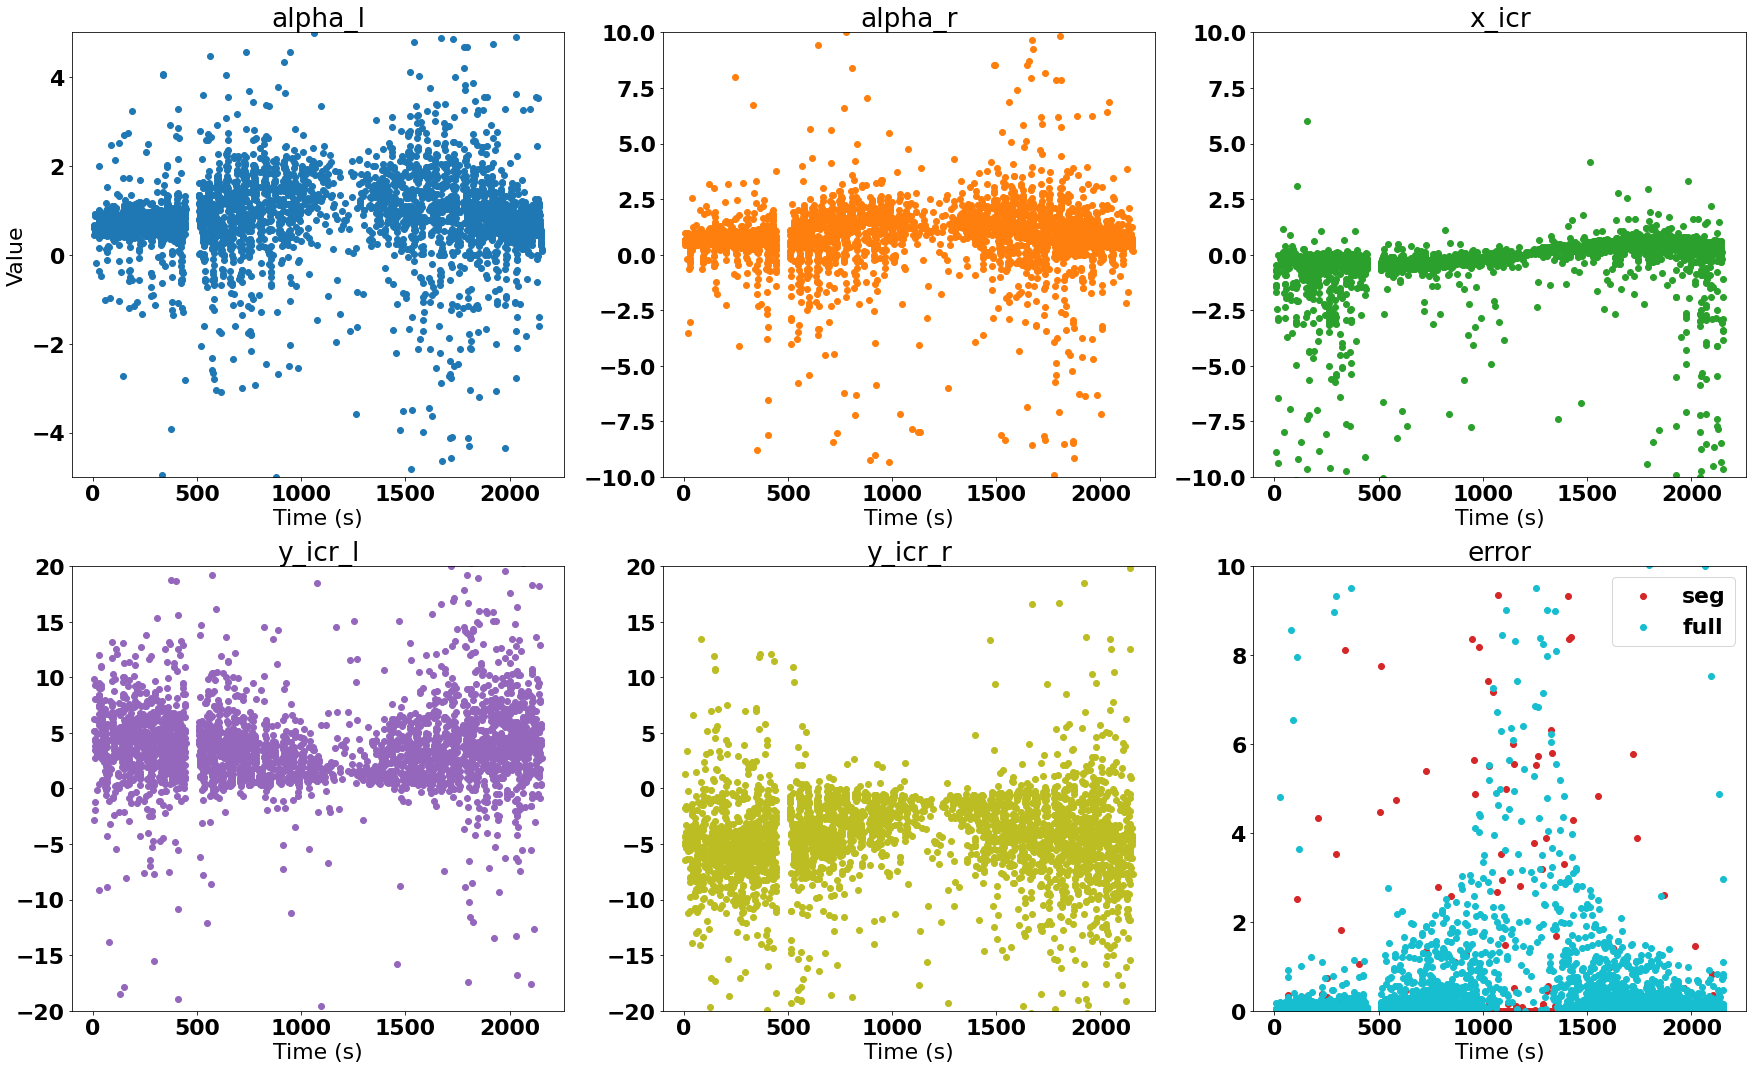

In [7]:
# plot parameter evolution

k_arr = np.delete(k_arr, (0), axis=0)

# print(k_arr[:, 0])

fig_1, axs1 = plt.subplots(2, 3, figsize = (30, 18))
axs1[0,0].scatter(k_arr[:, 0], k_arr[:, 3], color = 'tab:blue')
axs1[0,0].set_ylim([-5, 5])
axs1[0,0].set_title('alpha_l')
axs1[0,0].set_xlabel('Value')
axs1[0,0].set_ylabel('Value')

axs1[0,1].scatter(k_arr[:, 0], k_arr[:, 4], color = 'tab:orange')
axs1[0,1].set_ylim([-10, 10])
axs1[0,1].set_title('alpha_r')

axs1[0,2].scatter(k_arr[:, 0], k_arr[:, 5], color = 'tab:green')
axs1[0,2].set_ylim([-10, 10])
axs1[0,2].set_title('x_icr')

axs1[1,0].scatter(k_arr[:, 0], k_arr[:, 6], color = 'tab:purple')
axs1[1,0].set_ylim([-20, 20])
axs1[1,0].set_title('y_icr_l')

axs1[1,1].scatter(k_arr[:, 0], k_arr[:, 7], color = 'tab:olive')
axs1[1,1].set_ylim([-20, 20])
axs1[1,1].set_title('y_icr_r')

axs1[1,2].scatter(k_arr[:, 0], k_arr[:, 1], color = 'tab:red', label='seg')
axs1[1,2].scatter(k_arr[:, 0], k_arr[:, 2], color = 'tab:cyan', label='full')
axs1[1,2].set_ylim(0, 10)
axs1[1,2].legend()
axs1[1,2].set_title('error')

for ax in axs1.flat:
    ax.set(xlabel = 'Time (s)')
#     ax.set_ylim([-5, 5])

# for ax in axs1.flat:
#     ax.label_outer()


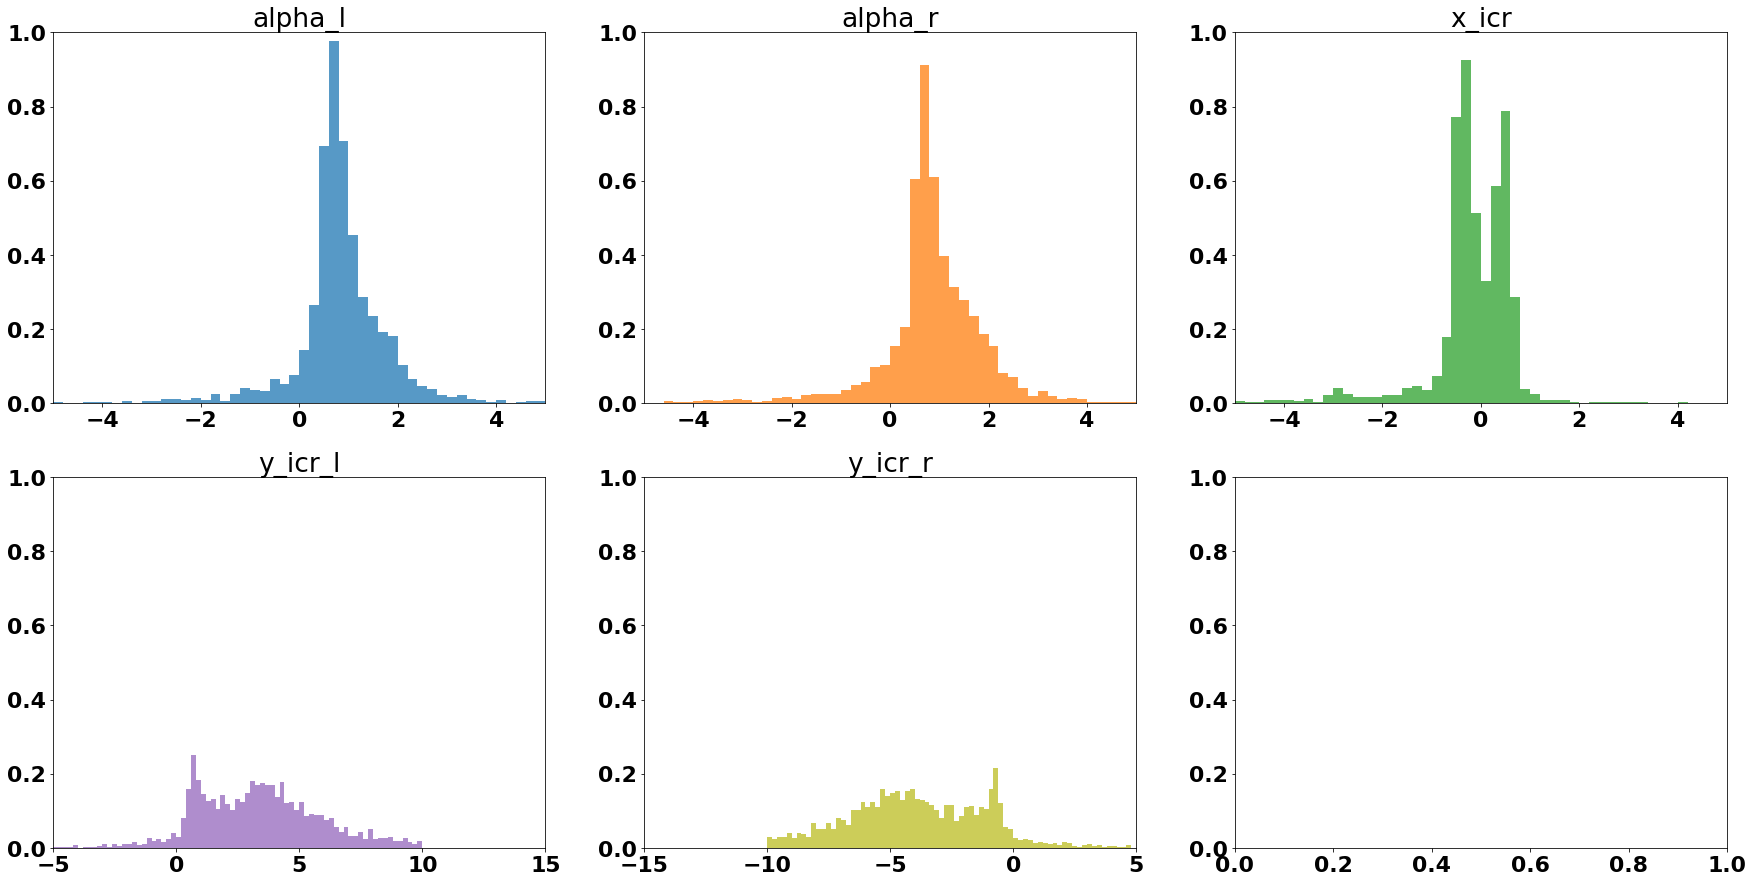

In [13]:
fig_2, axs2 = plt.subplots(2, 3, figsize = (30, 15))

axs2[0,0].hist(k_arr[:, 3], 100, density=True, facecolor='tab:blue', alpha=0.75, range = [-10.0, 10.0])
axs2[0,0].set_title('alpha_l')
axs2[0,0].set_xlim(-5, 5)
axs2[0,0].set_ylim(0, 1.0)

axs2[0,1].hist(k_arr[:, 4], 100, density=True, facecolor='tab:orange', alpha=0.75, range = [-10.0, 10.0])
axs2[0,1].set_title('alpha_r')
axs2[0,1].set_xlim(-5, 5)
axs2[0,1].set_ylim(0, 1.0)

axs2[0,2].hist(k_arr[:, 5], 100, density=True, facecolor='tab:green', alpha=0.75, range = [-10.0, 10.0])
axs2[0,2].set_title('x_icr')
axs2[0,2].set_xlim(-5, 5)
axs2[0,2].set_ylim(0, 1.0)

axs2[1,0].hist(k_arr[:, 6], 100, density=True, facecolor='tab:purple', alpha=0.75, range = [-10.0, 10.0])
axs2[1,0].set_title('y_icr_l')
axs2[1,0].set_xlim(-5, 15)
axs2[1,0].set_ylim(0, 1.0)

axs2[1,1].hist(k_arr[:, 7], 100, density=True, facecolor='tab:olive', alpha=0.75, range = [-10.0, 10.0])
axs2[1,1].set_title('y_icr_r')
axs2[1,1].set_xlim(-15, 5)
axs2[1,1].set_ylim(0, 1.0)

for ax in axs1.flat:
    ax.set(xlabel = 'Value (m)', ylabel = 'Value (m)')

plt.savefig('./figs/param_dist.png')